<a href="https://colab.research.google.com/github/MrDiamoN/MrDiamoN/blob/main/Processamento_de_imagem_e_Vis%C3%A3o_computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==========================================
## PROJETO COMPLETO: CLASSIFICAÇÃO DE IMAGENS COM CNN
## PLATAFORMA: Google Colab + TensorFlow
## OBJETIVO: Classificar imagens de gatos e cachorros
## ÊNFASE: Acurácia, avaliação, overfitting, interpretação visual
# ==========================================

### ====== 1. IMPORTAÇÃO DAS BIBLIOTECAS NECESSÁRIAS ======

In [21]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### ====== 2. DOWNLOAD E ORGANIZAÇÃO DO DATASET =====

In [2]:
# Baixando dataset do Kaggle (certifique-se de carregar seu token Kaggle.json no Colab)
#from google.colab import files
#files.upload()  # Vai abrir um seletor de arquivos, escolha o kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset
!unzip -q dog-and-cat-classification-dataset.zip
"""!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset
!unzip -q dog-and-cat-classification-dataset.zip"""

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset
License(s): apache-2.0


'!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset\n!unzip -q dog-and-cat-classification-dataset.zip'

In [22]:
# Diretórios principais
data_dir = "PetImages"
classes = ['Cat', 'Dog']
split_ratio = [0.8, 0.1, 0.1]
output_base_dir = "split_data"

In [23]:
# Criando pastas de treino/validação/teste
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(output_base_dir, split, cls), exist_ok=True)


In [24]:
# Distribuindo imagens
for cls in classes:
    path = os.path.join(data_dir, cls)
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png'))]
    random.shuffle(files)

    max_images_per_class = 5000  # limitar a quantidade por classe
    files = files[:max_images_per_class]

    train_split = int(len(files) * split_ratio[0])
    val_split = int(len(files) * (split_ratio[0] + split_ratio[1]))

    for i, file in enumerate(files):
        src = os.path.join(path, file)
        if i < train_split:
            dst = os.path.join(output_base_dir, 'train', cls, file)
        elif i < val_split:
            dst = os.path.join(output_base_dir, 'val', cls, file)
        else:
            dst = os.path.join(output_base_dir, 'test', cls, file)
        try:
            shutil.copyfile(src, dst)
        except:
            continue

### ====== 3. PRÉ-PROCESSAMENTO E AUMENTO DE DADOS ======

In [25]:
input_size = (128, 128)
batch_size = 64

In [26]:
# Gerador com normalização (muito importante para a rede aprender corretamente)
datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

train_gen = datagen.flow_from_directory("split_data/train", target_size=input_size, batch_size=batch_size, class_mode='categorical')
val_gen = datagen.flow_from_directory("split_data/val", target_size=input_size, batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory("split_data/test", target_size=input_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


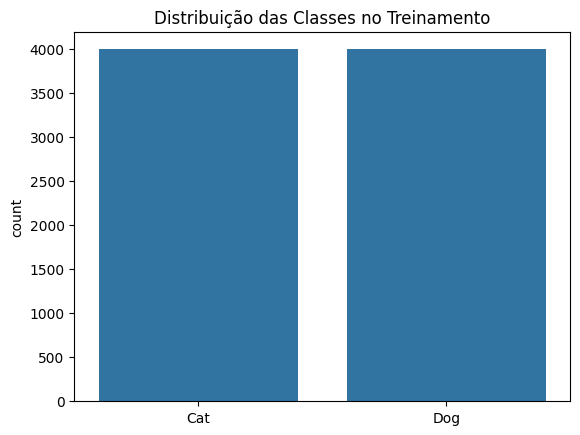

In [27]:
# Visualizando distribuição dos dados de treino
labels = train_gen.classes
sns.countplot(x=labels)
plt.title("Distribuição das Classes no Treinamento")
plt.xticks([0,1], train_gen.class_indices.keys())
plt.show()

### ====== 4. CONSTRUÇÃO DO MODELO CNN ======

In [30]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

"""
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])
"""

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

### ====== 5. TREINAMENTO DO MODELO ======

In [ ]:
#early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#history = model.fit(train_gen, epochs=12, validation_data=val_gen, callbacks=[early_stop])


from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(train_gen, epochs=12, validation_data=val_gen, callbacks=[early_stop])


Epoch 1/12
  1/125 ━━━━━━━━━━━━━━━━━━━━ 7:02 3s/step - accuracy: 0.5312 - loss: 0.7162

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


125/125 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.5451 - loss: 1.3321 - val_accuracy: 0.6720 - val_loss: 0.5999
Epoch 2/12
 20/125 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - accuracy: 0.6965 - loss: 0.5724

### ====== 6. AVALIAÇÃO DO MODELO ======

In [ ]:
loss, accuracy = model.evaluate(test_gen)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.8143 - loss: 0.4174
Acurácia no conjunto de teste: 0.7932


### ====== 7. GRÁFICOS DE ACURÁCIA E LOSS ======

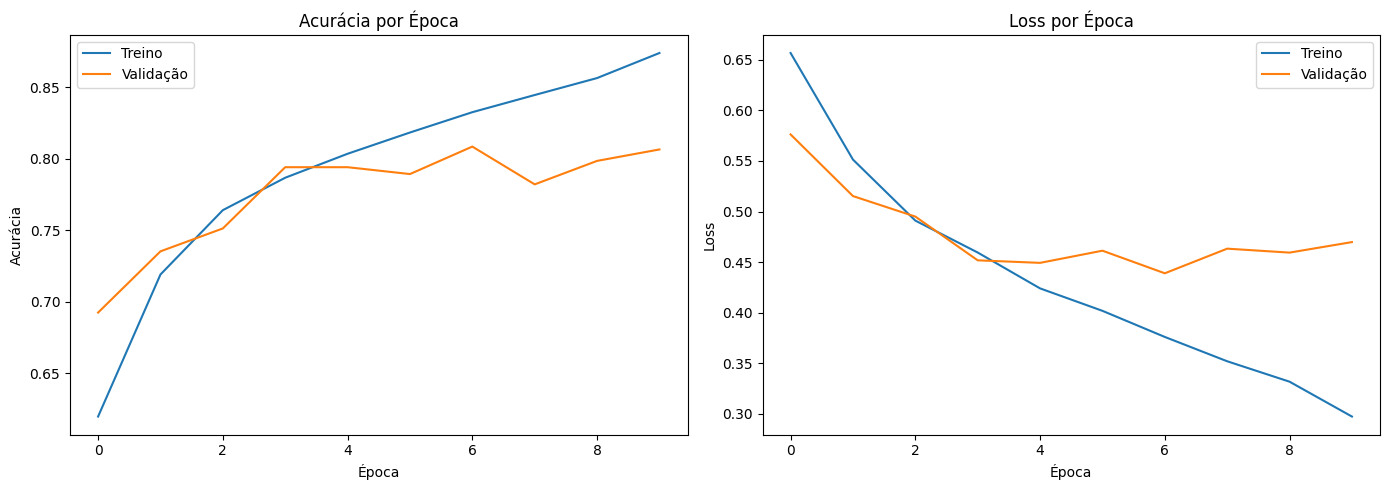

In [ ]:
def plot_metrics(hist):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Treino')
    plt.plot(hist.history['val_accuracy'], label='Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Treino')
    plt.plot(hist.history['val_loss'], label='Validação')
    plt.title('Loss por Época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(history)


### ====== 8. MATRIZ DE CONFUSÃO E CLASSIFICAÇÃO ======

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step


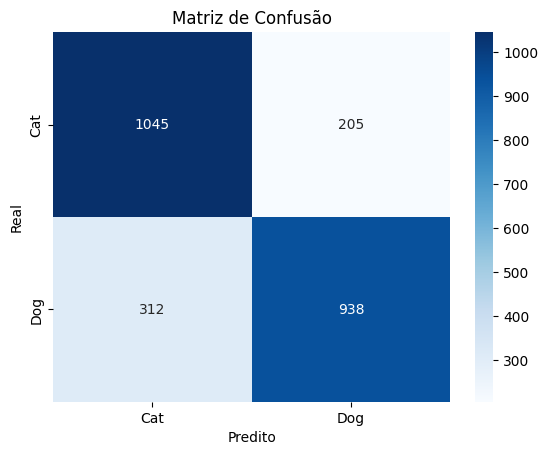


Relatório de Classificação:

              precision    recall  f1-score   support

         Cat       0.77      0.84      0.80      1250
         Dog       0.82      0.75      0.78      1250

    accuracy                           0.79      2500
   macro avg       0.80      0.79      0.79      2500
weighted avg       0.80      0.79      0.79      2500



In [ ]:
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

print("\nRelatório de Classificação:\n")
print(classification_report(y_true, y_pred_classes, target_names=classes))

### ====== 9. CURVA ROC ======

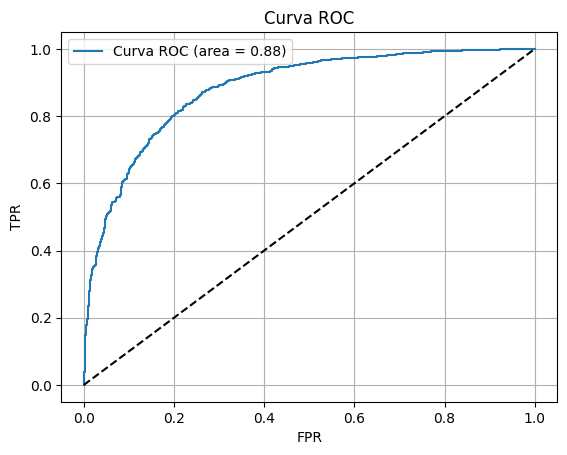

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_pred[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Curva ROC (area = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title('Curva ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

### ====== 10. INTERPRETAÇÃO FINAL ======

#### Acurácia é uma métrica que mede a proporção de acertos entre o total de previsões
#### A acurácia sozinha pode enganar se o conjunto de dados estiver desbalanceado
#### Outros sinais importantes vêm do comportamento das curvas de loss/acurácia
#### Overfitting: curva de treino sobe muito e a de validação estabiliza ou piora
#### Underfitting: ambas curvas de treino e validação ficam baixas
#### Melhorias possíveis: regularização, dropout, data augmentation, mais dados


## === FIM ===

In [19]:
import shutil

In [20]:
#Apagar a pasta split_data
shutil.rmtree('split_data')